In [6]:
using StaticArrays
using LinearAlgebra
using Makie
using CairoMakie
using Colors 


In [40]:
# Here, we define the three vectors connecting nearest neighbor Kagome atoms 

# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]



global const σx  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const σy  = @SArray ComplexF64[0.0 -im; im 0.0]
global const σz  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];
global const σ0  = @SArray ComplexF64[1.0 0.0; 0.0 1.0];

global const ρx  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const ρy  = @SArray ComplexF64[0.0 -im; im 0.0]
global const ρz  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];
global const ρ0  = @SArray ComplexF64[1.0 0.0; 0.0 1.0];



global const σ_up  = @SArray ComplexF64[1.0 0.0; 0.0 0.0];
global const σ_dn  = @SArray ComplexF64[0.0 0.0; 0.0 1.0];


global const TR1::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const TR2::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const TR3::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0]

global const TI1::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 im 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const TI2::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 0.0 -im; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const TI3::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [0.0 0.0 0.0; 0.0 0.0 im; 0.0 0.0 0.0]


global const λ0::SMatrix{3, 3, ComplexF64, 9} = @SMatrix [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]


global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = [-0.5, sqrt(3)/2]

global const A::SMatrix{2, 2, Float64, 4} = @SMatrix [A1[1] A1[2]; A2[1] A2[2]]
global const G::SMatrix{2, 2, Float64, 4} = 2.0 * π * inv(A)'
global const G1::SVector{2, Float64} = G[1, :]
global const G2::SVector{2, Float64} = G[2, :]

global const d1::Vector{Float64} = [0.0, 1.0, 0.0]
global const d2::Vector{Float64} = [-0.8660254037844386, -0.5, 0.0]
global const d3::Vector{Float64} = [-0.8660254037844386, -0.5, 0.0]

@inline function cartesian_to_reduced(k_cart::Vector{Float64}, G)
    inv(G)' * k_cart
end


global const Γ::Vector{Float64} = [0.0, 0.0]
global const K::Vector{Float64} = [0.666666666667, -0.3333333]
global const K′::Vector{Float64} = [0.33333333, 0.33333333333333]
global const M::Vector{Float64} = (K + K′) / 2.0 ;


# Useful functions 
@inline function kelvin_to_eV(Tk)
    Tk * 8.6e-5 
end 


kelvin_to_eV (generic function with 1 method)

### Hamiltonian and Velocity Matrices 

In [13]:
@inline function EvalsHamiltonian(k::SVector{2, Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = cos(π * k[1]); ck2::Float64 = cos(π * k[2])
    ck3::Float64 = cos(π * (-k[1] - k[2])) 

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return eigvals(Hermitian(H + H'))
end

@inline function EvalsHamiltonian(k::Vector{Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = cos(π * k[1]); ck2::Float64 = cos(π * k[2])
    ck3::Float64 = cos(π * (-k[1] - k[2])) 

   

    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return eigvals(Hermitian(H + H'))
end

@inline function EigensystemHamiltonian(k::Vector{Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = cos(π * k[1]); ck2::Float64 = cos(π * k[2])
    ck3::Float64 = cos(π * (-k[1] - k[2])) 

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return eigen(Hermitian(H + H'))
end


@inline function EigensystemHamiltonian(k::SVector{2, Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = cos(π * k[1]); ck2::Float64 = cos(π * k[2])
    ck3::Float64 = cos(π * (-k[1] - k[2])) 

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return eigen(Hermitian(H + H'))
end

@inline function Vx(k::SVector{2, Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = -π * sin(π * k[1]) * 0.15915 
    ck2::Float64 = π * sin(π * k[2]) * 0.079577
    ck3::Float64 = π * sin(π * (-k[1] - k[2])) * 0.079577 

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return H + H'
end

@inline function Vx(k::Vector{Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = -π * sin(π * k[1]) * 0.15915 
    ck2::Float64 = π * sin(π * k[2]) * 0.079577
    ck3::Float64 = π * sin(π * (-k[1] - k[2])) * 0.079577 

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return H + H'
end



@inline function Vy(k::SVector{2, Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = 0.0
    ck2::Float64 = -π * sin(π * k[2]) * 0.1378322
    ck3::Float64 = π * sin(π * (-k[1] - k[2])) * 0.1378322

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return H + H'
end

@inline function Vy(k::Vector{Float64}, λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64, 
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3)

    ck1::Float64 = 0.0
    ck2::Float64 = -π * sin(π * k[2]) * 0.1378322
    ck3::Float64 = π * sin(π * (-k[1] - k[2])) * 0.1378322

    
    σ1 = σy; σ2 = d2[1] * σx + d2[2] * σy; σ3 = d3[1] * σx + d3[2] * σy 

    H::SMatrix{6, 6, ComplexF64, 36} =  -2.0 * λR * (m1 * kron(σ1, ck1 * TI1) + m2 * kron(σ2, ck2 * TI2) + m3 * kron(σ3, ck3 * TI3)) +
                                (-2.0 * λI) * kron(σz, ck1 * TI1 + ck2 * TI2 + ck3 * TI3) +  
                                (-2.0) * kron(σ0, ck1 * TR1 + ck2 * TR2 + ck3 * TR3)
    return H + H'
end





Vy (generic function with 8 methods)

### Functions for calculating the Berry Curvature Polarizability Response of the Bands 

In [41]:
@inline function dFD_dk(E::Float64, μ::Float64, TKelv::Float64)
    """
    Derivatives of the Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    expf::Float64 = exp((11604.518 / TKelv) * (E - μ))
    if expf > 1e+7
        return 0.0
    end
    -(11604.518 / TKelv) * expf / (1.0 + expf)^2
end


@inline function BRrenorm_QM(k::SVector{2, Float64},
    λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    a::Int, b::Int, 
    d1::Vector{Float64} = d1, d2::Vector{Float64} = d2, d3::Vector{Float64} = d3
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - k Wave-fector = momentum / ħ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Quantum metric in the a, b direction as a 6 x 6 matrix  
    """

    (E, U) = EigensystemHamiltonian(k, λI, λR, m1, m2, m3, d1, d2, d3)
    Vx::Matrix{ComplexF64} = U' * Vx(k, λI, λR, m1, m2, m3, d1, d2, d3) * U
    Vy::Matrix{ComplexF64} = U' * Vy(k, λI, λR, m1, m2, m3, d1, d2, d3) * U

    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vx ./ ωmn, -im * Vy ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end


@inline function BRrenorm_QM(E::Vector{Float64}, Vmn::Vector{Matrix{ComplexF64}},
    a::Int, 
    b::Int
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """
    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    res = real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)
    res
end

@inline function BRrenorm_QM(E::SVector{6, Float64}, Vmn::Vector{Matrix{ComplexF64}},
    a::Int, 
    b::Int
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """
    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    res = real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)
    res
end


@inline function σ_BCPH_integrand(k::Vector{Float64}, E::Vector{Float64}, U::Matrix{ComplexF64}, 
    λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64})
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    Vx::Matrix{ComplexF64} = U' * Vx(k, λI, λR, m1, m2, m3, d1, d2, d3) * U
    Vy::Matrix{ComplexF64} = U' * Vy(k, λI, λR, m1, m2, m3, d1, d2, d3) * U

    Vmn = [Vx, Vy]

    bc = BRrenorm_QM(E, Vmn, b, c)
    ac = BRrenorm_QM(E, Vmn, a, c)
    ab = BRrenorm_QM(E, Vmn, a, b)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:6
        res += sum(2.0 * real(Vmn[a][m, m]) * bc[m, :] - real(Vmn[b][m, m]) * ac[m, :] - real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts
end

@inline function σ_BCPH_integrand(k::Vector{Float64}, E::SVector{6, Float64}, U::SMatrix{6, 6, ComplexF64}, 
    λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64})
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    vx::Matrix{ComplexF64} = U' * Vx(k, λI, λR, m1, m2, m3, d1, d2, d3) * U
    vy::Matrix{ComplexF64} = U' * Vy(k, λI, λR, m1, m2, m3, d1, d2, d3) * U

    Vmn = [vx, vy]

    bc = BRrenorm_QM(E, Vmn, b, c)
    ac = BRrenorm_QM(E, Vmn, a, c)
    ab = BRrenorm_QM(E, Vmn, a, b)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1 : 6
        res += sum(2.0 * real(Vmn[a][m, m]) * bc[m, :] - real(Vmn[b][m, m]) * ac[m, :] - real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts
end

function σ_BCPH(;λI::Float64, λR::Float64, m1::Float64, m2::Float64, m3::Float64,
    TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int,
    G::SMatrix{2, 2, Float64} = G,
    d1::Vector{Float64} = d1,
    d2::Vector{Float64} = d2,
    d3::Vector{Float64} = d3)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = det(G)
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    
    # First, generate momentum grid 
    rng = LinRange(-0.5, 0.5, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, k1) ∈ enumerate(rng)
        for (m, k2) ∈ enumerate(rng)
            grid[n, m] = [k1, k2]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for i ∈ 1 : nps 
        for j ∈ 1 : nps 
            k = grid[i, j]
            (E, U) = EigensystemHamiltonian(k, λI, λR, m1, m2, m3, d1, d2, d3)
            res    += σ_BCPH_integrand(k, E, U, λI, λR, m1, m2, m3, a, b, c, TKelv, μvals)
        end
    end
    
    res * dkxdky
end




σ_BCPH (generic function with 1 method)

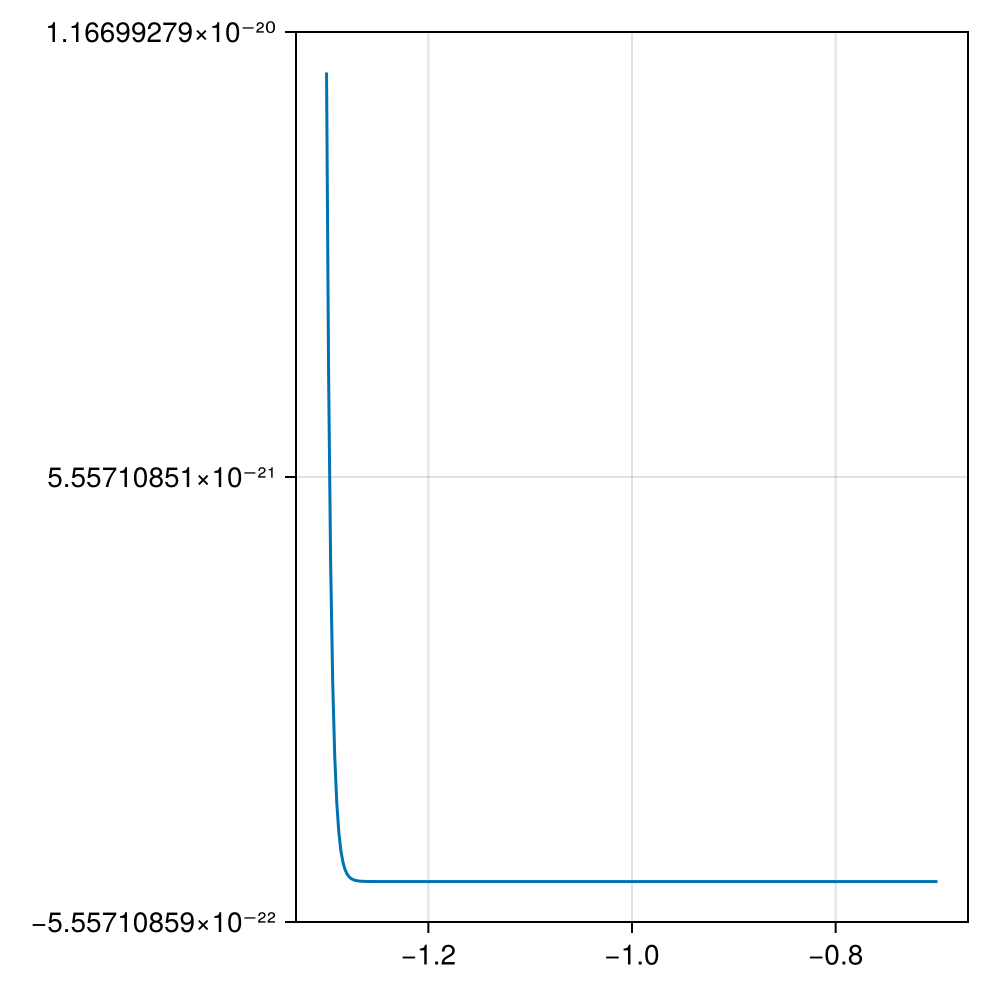

┌ Warning: No strict ticks found
└ @ PlotUtils /home/nabil/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /home/nabil/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [69]:
let λI::Float64 = 0.1, λR::Float64 = 0.5, m1::Float64 = 2.0, m2::Float64 = 1.0, m3::Float64 = 0.5,
    μmin = -1.3, μmax = -0.7, μnum = 300, nps = 1000, TKelv = 50.0


    # Chemical Potential 
    μvals = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(λI = λI, λR = λR, m1 = m1, m2 = m2, m3 = m3, a = 1, b = 2, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    
    f = Figure(size = (500, 500))
    ax = Axis(f[1, 1])
    lines!(ax, μvals, res1)
    f
end


In [129]:
let 
    Size = (3500, 1700)
    FontSize = 40

    # Second column 
    λI_1 = 0.1 
    λR_1 = 0.1 
    m1_1 = 1.0 
    m2_1 = 1.5
    m3_1 = 0.5 

    min_1 = -4.0
    max_1 = -1.0

    μmin_1 = -1.4; μmax_1 = -0.6


    # Third Column 
    λI_2 = 0.0 
    λR_2 = 0.0 
    m1_2 = 0.0 
    m2_2 = 0.0 
    m3_2 = 0.0 

    min_2 = -4.0
    max_2 = -1.0

    μmin_2 = -1.4; μmax_2 = -0.6


    # Fourth Column 
    λI_3 = 0.0 
    λR_3 = 0.0 
    m1_3 = 0.0 
    m2_3 = 0.0 
    m3_3 = 0.0 

    min_3 = -4.0
    max_3 = -1.0

    μmin_3 = -1.4; μmax_3 = -0.6


    # Contour plots contrlols 
    nps_contour = 300 
    kmin_contour = -6.5
    kmax_contour = 6.5 
    band_contour = 1


    # Transport 
    nps_transport = 1000
    μnum = 400
    TKelv = 50.0
    a = 2 
    b = 1 
    c = 1 



    # Transport 
    σ1 = σ_BCPH(λI = λI_1, λR = λR_1, m1 = m1_1, m2 = m2_1, m3 = m3_1, 
        a = a, b = b, c = c, 
        TKelv = TKelv, nps = nps_transport, 
        μmin = μmin_1, μmax = μmax_1, 
        μnum = μnum)

    σ2 = σ_BCPH(λI = λI_2, λR = λR_2, m1 = m1_2, m2 = m2_2, m3 = m3_2, 
        a = a, b = b, c = c, 
        TKelv = TKelv, nps = nps_transport, 
        μmin = μmin_2, μmax = μmax_2, 
        μnum = μnum)

    σ3 = σ_BCPH(λI = λI_3, λR = λR_3, m1 = m1_3, m2 = m2_3, m3 = m3_3, 
        a = a, b = b, c = c, 
        TKelv = TKelv, nps = nps_transport, 
        μmin = μmin_3, μmax = μmax_3, 
        μnum = μnum)

    σ = [σ1, σ2, σ3]

    # Chemical Potential 
    μvals = [LinRange(μmin_1, μmax_1, μnum), LinRange(μmin_2, μmax_2, μnum), LinRange(μmin_3, μmax_3, μnum)]

    μmin = [μmin_1, μmin_2, μmin_3]; μmax = [μmax_1, μmax_2, μmax_3]





    # Band Structure 
    Color_Fill = "#4cd137"
    Color_Fill = parse(Colorant, Color_Fill) 
    Alpha_Band = 0.07
    Color_Fill = RGBA(Color_Fill.r, Color_Fill.g, Color_Fill.b, Alpha_Band)
    Color_HorizontalDash = "#44bd32"

    

    nps_bands::Int = 300; Color_bands = "#e84118"
    ΓK = collect(LinRange(Γ, K, nps_bands)); pop!(ΓK) 
    KM = collect(LinRange(K, M, nps_bands)); pop!(KM)
    MΓ = collect(LinRange(M, Γ, nps_bands))
    ΓKMΓ = [ΓK; KM; MΓ]; nk = length(ΓKMΓ)  
    # xs 
    xs = Vector{Float64}(undef, nk)
    xs[1] = 0.0 
    ϵ::Float64 = 0.0 
    for ik ∈ 2 : nk
        ϵ += norm(ΓKMΓ[ik, :] - ΓKMΓ[ik - 1, :])
        xs[ik] = ϵ
    end
    Kpos     = norm(K); Mpos = norm(K) + norm(M - K);
    tick_pos = [0.0, Kpos, Mpos, xs[end]]
    tick_labels = ["Γ", "K", "M", "Γ"]

    Ysmin = similar(xs); Ysmax = similar(xs)



    eks_bands_1 = EvalsHamiltonian.(ΓKMΓ, Ref(λI_1), Ref(λR_1), Ref(m1_1), Ref(m2_1), Ref(m3_1))
    eks_bands_2 = EvalsHamiltonian.(ΓKMΓ, Ref(λI_2), Ref(λR_2), Ref(m1_2), Ref(m2_2), Ref(m3_2))
    eks_bands_3 = EvalsHamiltonian.(ΓKMΓ, Ref(λI_3), Ref(λR_3), Ref(m1_3), Ref(m2_3), Ref(m3_3))

    eks_bands = [eks_bands_1, eks_bands_2, eks_bands_3]


    # Contour Plots 
    min_contour = [min_1, min_2, min_3]
    max_contour = [max_1, max_2, max_3]

    kxs_contour = LinRange(kmin_contour, kmax_contour, nps_contour)
    kys_contour = LinRange(kmin_contour, kmax_contour, nps_contour)

    ks_contour = Matrix{Vector{Float64}}(undef, nps_contour, nps_contour)
    for i ∈ 1 : nps_contour
        for j ∈ 1 : nps_contour
            ks_contour[i, j] = [kxs_contour[i], kys_contour[j]]
        end
    end

    ks_contour = cartesian_to_reduced.(ks_contour, Ref(G))
    eks_contour_1 = EvalsHamiltonian.(ks_contour, Ref(λI_1), Ref(λR_1), Ref(m1_1), Ref(m2_1), Ref(m3_1))
    eks_contour_2 = EvalsHamiltonian.(ks_contour, Ref(λI_2), Ref(λR_2), Ref(m1_2), Ref(m2_2), Ref(m3_2))
    eks_contour_3 = EvalsHamiltonian.(ks_contour, Ref(λI_3), Ref(λR_3), Ref(m1_3), Ref(m2_3), Ref(m3_3))

    eks_contour_1 = [eks_contour_1[i, j][band_contour] for i ∈ 1:nps_contour, j ∈ 1:nps_contour]
    eks_contour_2 = [eks_contour_2[i, j][band_contour] for i ∈ 1:nps_contour, j ∈ 1:nps_contour]
    eks_contour_3 = [eks_contour_3[i, j][band_contour] for i ∈ 1:nps_contour, j ∈ 1:nps_contour]

    eks_contour = [eks_contour_1, eks_contour_2, eks_contour_3]


    # Lattice 
    # ----------------------------
    # First, compute the atom positions 
    a = 0.5 * (A1 + A2)
    b = 0.5 * A1 
    c = 0.5 * A2 

    box_ln::Float64 = π / 2

    Λ::Int = 4
    a_points = Vector{Vector{Float64}}(undef, (2 * Λ + 1)^2)
    b_points = Vector{Vector{Float64}}(undef, (2 * Λ + 1)^2)
    c_points = Vector{Vector{Float64}}(undef, (2 * Λ + 1)^2)
    counter::Int = 1
    for n ∈ -Λ:Λ
        for m ∈ -Λ:Λ
            a_points[counter] = a + n * A1 + m * A2
            counter += 1 
        end
    end
    counter = 1 
    for n ∈ -Λ:Λ
        for m ∈ -Λ:Λ
            b_points[counter] = b + n * A1 + m * A2
            counter += 1 
        end
    end
    counter = 1
    for n ∈ -Λ:Λ
        for m ∈ -Λ:Λ
            c_points[counter] = c + n * A1 + m * A2
            counter += 1 
        end
    end

    # Distance between the atoms 
    Distance::Float64 = norm(a - b)

    NNPairs_AB = Tuple{Vector{Float64}, Vector{Float64}}[]
    for a ∈ a_points
        for b ∈ b_points
            d = norm(a - b) 
            if (abs(d - Distance) < 1e-6)
                push!(NNPairs_AB, (a, b))
            end
        end
    end

    NNPairs_AC = Tuple{Vector{Float64}, Vector{Float64}}[]
    for a ∈ a_points
        for c ∈ c_points
            d = norm(a - c) 
            if (abs(d - Distance) < 1e-6)
                push!(NNPairs_AC, (a, c))
            end
        end
    end

    NNPairs_BC = Tuple{Vector{Float64}, Vector{Float64}}[]
    for b ∈ b_points
        for c ∈ c_points
            d = norm(b - c) 
            if (abs(d - Distance) < 1e-6)
                push!(NNPairs_BC, (b, c))
            end
        end
    end




    f = Figure(size = Size)
    # Main Layout 
    g     = f[1, 1:2] = GridLayout()
    # Part to hold the axis for the Kagome Lattice 
    gl    = g[1, 1] = GridLayout()
    # Axes containing Computations
    grest = g[1, 2] = GridLayout()

    # Split to three different columns 
    abc = grest[1, 1]
    dfe = grest[1, 2]
    ghi = grest[1, 3]

    aa = abc[1, 1] = GridLayout()
    bb = abc[2, 1] = GridLayout()
    cc = abc[3, 1] = GridLayout()

    dd = dfe[1, 1] = GridLayout()
    ee = dfe[2, 1] = GridLayout()
    ff = dfe[3, 1] = GridLayout()

    gg = ghi[1, 1] = GridLayout()
    hh = ghi[2, 1] = GridLayout()
    ii = ghi[3, 1] = GridLayout()

    # Lattice 
    axl = Axis(gl[1, 1], spinewidth = 4.5, limits = (-box_ln, box_ln, -box_ln, box_ln)) 

    axa = Axis(aa[1, 1], ylabel = "E (eV)", 
        yticklabelsize = FontSize, xticklabelsize = FontSize, 
        ylabelsize = FontSize, xlabelsize = FontSize,
        spinewidth = 3,
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)
    axa.xticks = (tick_pos, tick_labels)

    axb = Axis(bb[1, 1],
        ylabel = L"$k_y$",
        xlabel = L"$k_x$",
        yticklabelsize = FontSize + 20,
        xticklabelsize = FontSize + 20,
        ylabelsize = FontSize + 20,
        xlabelsize = FontSize + 20,
        spinewidth = 3,
        limits = (kxs_contour[1], kxs_contour[end], kys_contour[1], kys_contour[end]),
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3
    )
    axc = Axis(cc[1, 1], spinewidth = 3, xticklabelsize = FontSize, yticklabelsize = FontSize,
            xlabelsize = FontSize, ylabelsize = FontSize,
            xlabel = "μ", ylabel = "σ",
            xticksmirrored = true, yticksmirrored = true,
            xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)

    axd = Axis(dd[1, 1], ylabel = "E (eV)", 
        yticklabelsize = FontSize, xticklabelsize = FontSize, 
        ylabelsize = FontSize, xlabelsize = FontSize,
        spinewidth = 3,
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)
    axd.xticks = (tick_pos, tick_labels)

    axe = Axis(ee[1, 1],
        ylabel = L"$k_y$",
        xlabel = L"$k_x$",
        yticklabelsize = FontSize + 20,
        xticklabelsize = FontSize + 20,
        ylabelsize = FontSize + 20,
        xlabelsize = FontSize + 20,
        spinewidth = 3,
        limits = (kxs_contour[1], kxs_contour[end], kys_contour[1], kys_contour[end]),
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)

    axf = Axis(ff[1, 1], spinewidth = 3, xticklabelsize = FontSize, yticklabelsize = FontSize,
        xlabelsize = FontSize, ylabelsize = FontSize,
        xlabel = "μ", ylabel = "σ",
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)

    axg = Axis(gg[1, 1], ylabel = "E (eV)", 
        yticklabelsize = FontSize, xticklabelsize = FontSize, 
        ylabelsize = FontSize, xlabelsize = FontSize,
        spinewidth = 3,
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)
    axg.xticks = (tick_pos, tick_labels)

    axh = Axis(hh[1, 1],
        ylabel = L"$k_y$",
        xlabel = L"$k_x$",
        yticklabelsize = FontSize + 20,
        xticklabelsize = FontSize + 20,
        ylabelsize = FontSize + 20,
        xlabelsize = FontSize + 20,
        spinewidth = 3,
        limits = (kxs_contour[1], kxs_contour[end], kys_contour[1], kys_contour[end]),
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)


    axi = Axis(ii[1, 1], spinewidth = 3, xticklabelsize = FontSize, yticklabelsize = FontSize,
        xlabelsize = FontSize, ylabelsize = FontSize,
        xlabel = "μ", ylabel = "σ",
        xticksmirrored = true, yticksmirrored = true,
        xticksize = 7, xtickwidth = 3, yticksize = 7, ytickwidth = 3)

    colsize!(g, 1, Aspect(1.0, 1.0))


    axes_bands = [axa, axd, axg]
    axes_contour = [axb, axe, axh]
    axes_transport = [axc, axf, axi]

    # Transport
    for i ∈ 1 : 3
        ax = axes_transport[i]
        μs = μvals[i]
        σs = σ[i]
        lines!(ax, μs, σs, linewidth = 5.0, color = "#192a56")
    end




    # Band Structure 
    for i ∈ 1 : 3
        ax = axes_bands[i]; eks = eks_bands[i]
        for i ∈ 1 : 6
            ee = [e[i] for e ∈ eks]
            lines!(ax, xs, ee, color = Color_bands, linewidth = 3)

            vlines!(ax, [Kpos, Mpos], color = (0, 0, 1, 0.3), linewidth = 4, linestyle = :dash)

            fill!(Ysmin, μmin[i]); fill!(Ysmax, μmax[i])

            hlines!(ax, [μmin[i], μmax[i]], color = Color_HorizontalDash, linewidth = 4, linestyle = :dash)
            band!(ax, xs, Ysmin, Ysmax, color = Color_Fill)

            hideydecorations!(ax, grid = true, label = false, ticks = false, ticklabels = false)
            hidexdecorations!(ax, grid = true, ticks = false, ticklabels = false)
            
        end
    end

    # Contour Plots 
    for i ∈ 1 : 3
        ax = axes_contour[i]
        eks = eks_contour[i]
        contour!(ax, kxs_contour, kys_contour, eks, levels = min_contour[i]:0.05:max_contour[i], colormap = :RdBu, linewidth = 2)
        hideydecorations!(ax, grid = true, label = false, ticks = false, ticklabels = false)
        hideydecorations!(ax, grid = true, label = false, ticks = false, ticklabels = false)
    end




    # Lattice 
    # Parallelogram 
    vertices = Point2f[(0,0), (A1[1], A1[2]), (A2[1], A2[2]), (A1[1] + A2[1], A1[2] + A2[2])]

    ParallelogramColor = "#F79F1F" # Pico void color 
    ParallelogramColor = parse(Colorant, ParallelogramColor) 
    Alpha = 0.07
    ParallelogramColor = RGBA(ParallelogramColor.r, ParallelogramColor.g, ParallelogramColor.b, Alpha)
    
    mesh!(axl, vertices, [1 2 3; 2 4 3], color = ParallelogramColor)

    # Basis 
    BasisColor = "#192a56" # Pico void color 
    BasisColorIn = parse(Colorant, BasisColor) 
    Alpha = 0.9
    BasisColorIn = RGBA(BasisColorIn.r, BasisColorIn.g, BasisColorIn.b, Alpha)
    Start_xs = [0.0, 0.0, A2[1], A1[1]]
    Start_ys = [0.0, 0.0, A2[2], A1[2]]
    Arrows_xs = [A1[1], A2[1], A1[1], A2[1]]
    Arrows_ys = [A1[2], A2[2], A1[2], A2[2]]
    arrows!(axl, Start_xs, Start_ys, Arrows_xs, Arrows_ys, linewidth = 7, 
            color = BasisColorIn, arrowsize = 20.6)

    
    # Lattice Edges 
    for (a, b) ∈ NNPairs_AB
        lines!(axl, [a[1], b[1]], [a[2], b[2]], color = :black, linewidth = 4)
    end
    for (a, c) ∈ NNPairs_AC
        lines!(axl, [a[1], c[1]], [a[2], c[2]], color = :black, linewidth = 4)
    end
    for (b, c) ∈ NNPairs_BC
        lines!(axl, [b[1], c[1]], [b[2], c[2]], color = :black, linewidth = 4)
    end
    # Plot the A, B, and C sites 
    AtomSize = FontSize
    AtomColor = "#b33939"
    for a ∈ a_points
        scatter!(axl, a[1], a[2], markersize = AtomSize, color = AtomColor)
    end
    for b ∈ b_points
        scatter!(axl, b[1], b[2], markersize = AtomSize, color = AtomColor)
    end
    for c ∈ c_points
        scatter!(axl, c[1], c[2], markersize = AtomSize, color = AtomColor)
    end
    
    text!(
        axl, A1[1], A1[2],
        text = "A₁",
        font = :bold,
        align = (:left, :top),
        offset = (4, -2),
        #space = :relative,
        fontsize = FontSize + 30
    )
    text!(
        axl, A2[1], A2[2],
        text = "A₂",
        font = :bold,
        align = (:left, :bottom),
        offset = (4, 2),
        #space = :relative,
        fontsize = FontSize + 30
    )

    # A, B, C Sites 
    text!(
        axl, a[1], a[2],
        text = "a",
        font = :bold,
        align = (:left, :bottom),
        offset = (4, -2),
        #space = :relative,
        fontsize = FontSize + 30,
        color = "#009432"
    )

    text!(
        axl, b[1] + A2[1], b[2] + A2[2],
        text = "c",
        font = :bold,
        align = (:left, :bottom),
        offset = (4, -2),
        #space = :relative,
        fontsize = FontSize + 30,
        color = "#009432"
    )

    text!(
        axl, c[1], c[2],
        text = "b",
        font = :bold,
        align = (:left, :bottom),
        offset = (4, -2),
        #space = :relative,
        fontsize = FontSize + 30,
        color = "#009432"
    )

    nac = [sqrt(3) / 2.0, 0.5]
    ncb = [-sqrt(3) / 2.0, 0.5]
    nab = [0.0, -1.0]
    scale = 4

    RashbaArrowColor = "#00a8ff" # Pico void color 
    RashbaArrowColor = parse(Colorant, RashbaArrowColor) 
    Alpha = 0.5
    RashbaArrowColor = RGBA(RashbaArrowColor.r, RashbaArrowColor.g, RashbaArrowColor.b, Alpha)

    centroid = (a + c + b + A2) / 3.0  
    # Rashba "flux "
    Rashba_X₋ = [centroid[1], centroid[1], centroid[1]] 
    Rashba_Y₋ = [centroid[2], centroid[2], centroid[2]]
    Rashba_X₊ = [nab[1], ncb[1], nac[1]] ./ scale 
    Rashba_Y₊ = [nab[2], ncb[2], nac[2]] ./ scale
    arrows!(axl, Rashba_X₋, Rashba_Y₋, Rashba_X₊, Rashba_Y₊, linewidth = 11, 
            color = RashbaArrowColor, arrowsize = 25.6)

    hidespines!(axl)
    hidexdecorations!(axl)
    hideydecorations!(axl)

    save("test.png", f)
    
    f
end

UndefVarError: UndefVarError: `μ_min3` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
let nps = 200, λI = 0.1, λR = 0.1, m1 = 1.0, m2 = 1.5, m3 = 0.5
    ΓK = collect(LinRange(Γ, K, nps)); pop!(ΓK) 
    KM = collect(LinRange(K, M, nps)); pop!(KM)
    MΓ = collect(LinRange(M, Γ, nps))
    ΓKMΓ = [ΓK; KM; MΓ]; nk = length(ΓKMΓ) 
    # Diagonalize 
    Evals = EvalsHamiltonian.(ΓKMΓ, Ref(λI), Ref(λR), Ref(m1), Ref(m2), Ref(m3))
    
    # xs 
    xs = Vector{Float64}(undef, nk)
    xs[1] = 0.0 
    ϵ::Float64 = 0.0 
    for ik ∈ 2 : nk
        ϵ += norm(ΓKMΓ[ik, :] - ΓKMΓ[ik - 1, :])
        xs[ik] = ϵ
    end
    Kpos     = norm(K); Mpos = norm(K) + norm(M - K);
    tick_pos = [0.0, Kpos, Mpos, xs[end]]
    tick_labels = ["Γ", "K", "M", "Γ"]

    f = Figure(size = (600, 600))
    FontSize = 30 
    ax = Axis(f[1, 1], ylabel = "E (eV)", 
        yticklabelsize = FontSize, xticklabelsize = FontSize, 
        ylabelsize = FontSize, xlabelsize = FontSize,
        spinewidth = 3) 

    ax.xticks = (tick_pos, tick_labels)

    Color = "#e84118"

    for i ∈ 1 : 6
        eks = [e[i] for e ∈ Evals]
        lines!(ax, xs, eks, color = Color, linewidth = 3)
    end



    hideydecorations!(ax, grid = true, label = false, ticks = false, ticklabels = false)
    hidexdecorations!(ax, grid = true, ticks = false, ticklabels = false)
    vlines!(ax, [Kpos, Mpos], color = (0, 0, 1, 0.3), linewidth = 4, linestyle = :dash)

    # Band 
    μmin = -1.4
    μmax = -0.6

    Color_Band = "#4cd137"
    Color_Fill = "#4cd137"
    Color_Fill = parse(Colorant, Color_Fill) 
    Alpha_Band = 0.07
    Color_Fill = RGBA(Color_Fill.r, Color_Fill.g, Color_Fill.b, Alpha_Band)

    
    Ysmin = similar(xs); Ysmax = similar(xs)
    fill!(Ysmin, μmin); fill!(Ysmax, μmax)
    hlines!(ax, [μmin, μmax], color = Color_Band, linewidth = 4, linestyle = :dash)
    band!(ax, xs, Ysmin, Ysmax, color = Color_Fill)


    f
    

end

UndefVarError: UndefVarError: `Color_Band` not defined in `Main`
Suggestion: check for spelling errors or missing imports.